In [ ]:
#default_exp fingerprints

# Fingerprints 

> From element maps to media maps 

In [ ]:
#hide 
%load_ext autoreload
%autoreload 2 
%matplotlib notebook

In [ ]:
# hide 
import os 
os.chdir('/home/frank/Work/Projecten/DoRe/viz/raw_nmf')

In [ ]:
#hide 
import numpy as np 
import matplotlib.pyplot as plt 
import skimage.exposure as ske

from maxrf4u import DataStack

In [ ]:
#hide 
ds = DataStack('RP-T-1898-A-3689.datastack') 
extent = ds.read('imvis_extent')
imvis = ds.read('imvis_reg_highres')

x_keVs = ds.read('maxrf_energies') 
y_max = ds.read('maxrf_maxspectrum')
y_sum = ds.read('maxrf_sumspectrum') 

hotmax_pixels = ds.read('hotmax_pixels')
hotmax_spectra = ds.read('hotmax_spectra')
hotmax_baselines = ds.read('hotmax_baselines')

peak_idxs = hotmax_pixels[:,2]

**Need to elaborate on this later...**

From my perspective element maps are nice as such. However the ultimate question is: Why do we find which elements where? What do we learn about the materials used by the artist? Paper, ink, paint?  

Let's see what happens if we apply NMF again, this time without imposing any information on the components. Let's plot the element maps that we will now use as an input to create our ultimate media maps. 

In [ ]:
import sklearn.decomposition as skd 
from maxrf4u import multi_plot

In [ ]:
elements = ds.read('nmf_elements') 
element_maps = ds.read('nmf_elementmaps')

element_maps_histeq = [ske.equalize_hist(m) for m in element_maps]

<IPython.core.display.Javascript object>


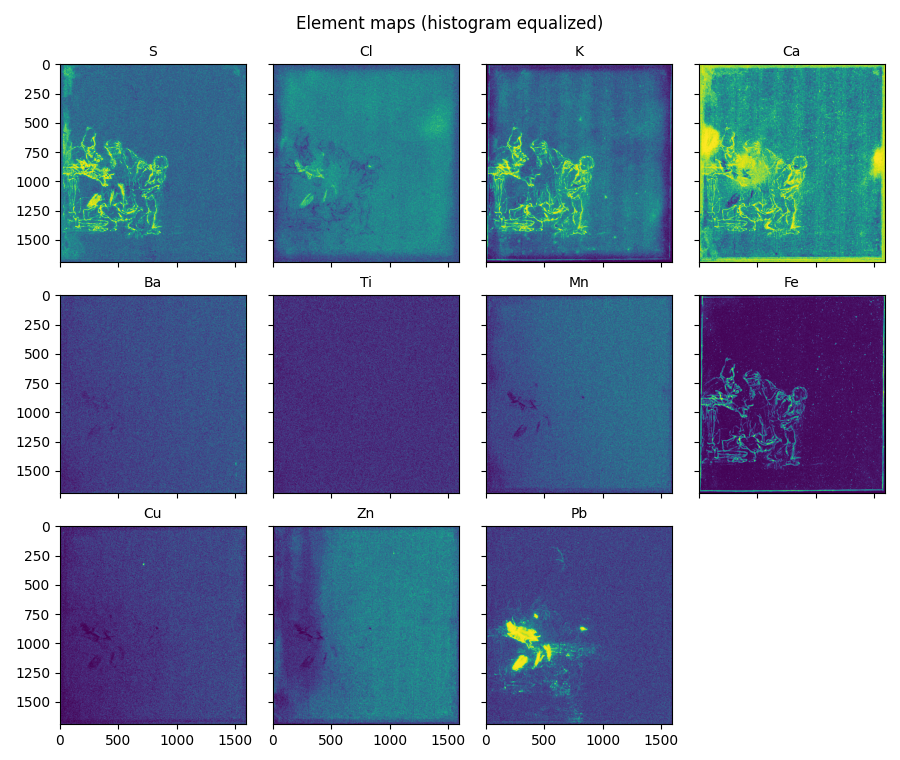

In [ ]:
fig, axs = multi_plot(*element_maps_histeq,titles=elements)
fig.suptitle('Element maps (histogram equalized)')
plt.tight_layout()

## Histogram and false color image exploration 

Let's normalize our element maps right from the start. 

In [ ]:
elements = ds.read('nmf_elements') 
element_maps = ds.read('nmf_elementmaps')

In [ ]:
element_stack = element_maps.transpose([1, 2, 0])
h, w, d = element_stack.shape

map_maxima = np.max(element_stack.reshape([h * w, d]), axis=0)
element_stack = element_stack / map_maxima[None, None, :]

<IPython.core.display.Javascript object>


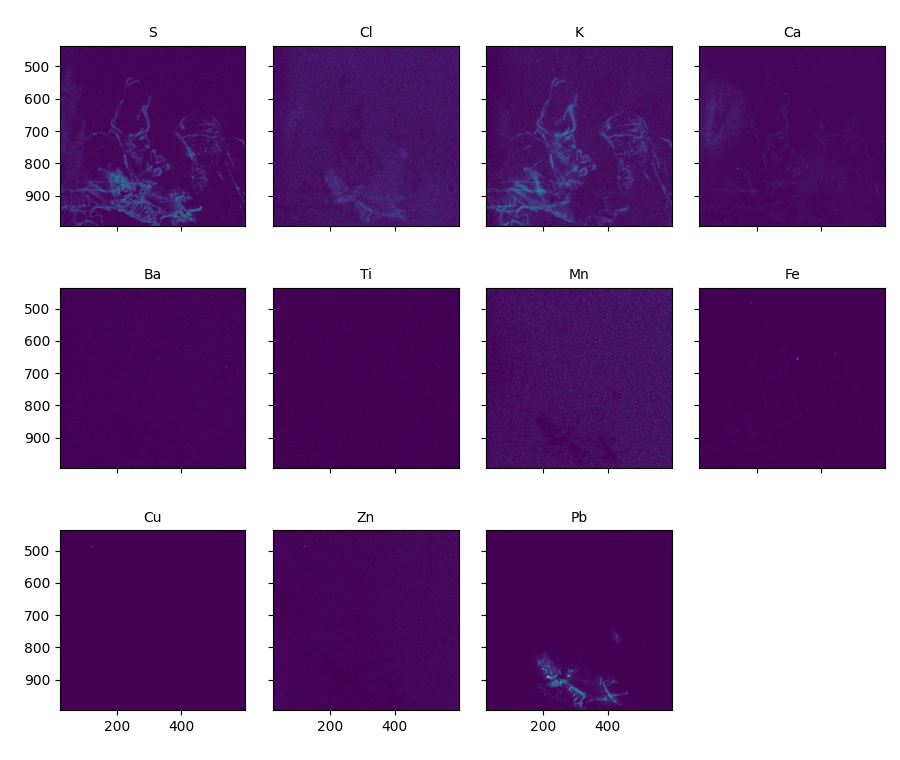

In [ ]:
multi_plot(*element_stack.transpose([2, 0, 1]), titles=elements);

## Automatic NMF? 

**Not working yet...**

For further experimentation let's first try a part of the drawing. 

In [ ]:
element_stack = element_maps[:, 700:1000, 700:1000].transpose([1, 2, 0])

h, w, d = element_stack.shape

# flatten into list 
X = element_stack.reshape([h * w, d])

In [ ]:
n_components = 9
H, W, n_iter = skd.non_negative_factorization(X, n_components=n_components, init='nndsvda', max_iter=1000)

<IPython.core.display.Javascript object>


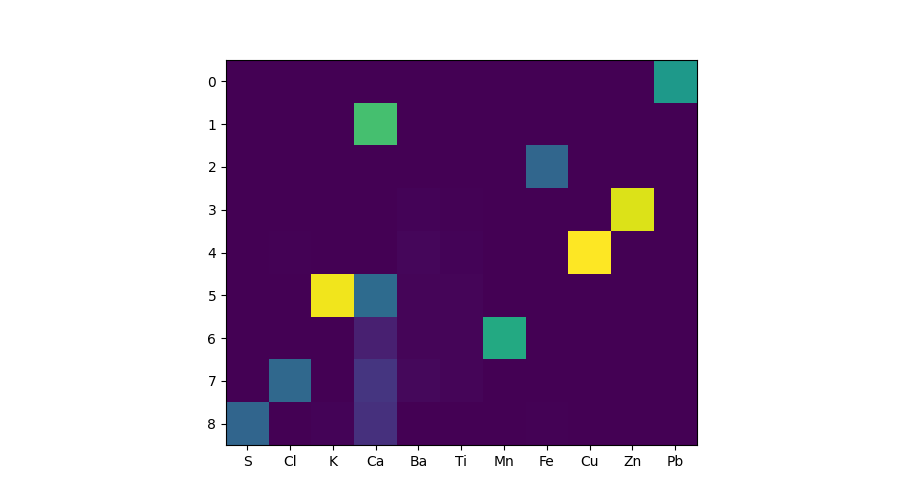

In [ ]:
fig, ax = plt.subplots(figsize=[9, 5])
ax.imshow(W)
ax.set_xticks(range(len(elements)), labels=elements);

<IPython.core.display.Javascript object>


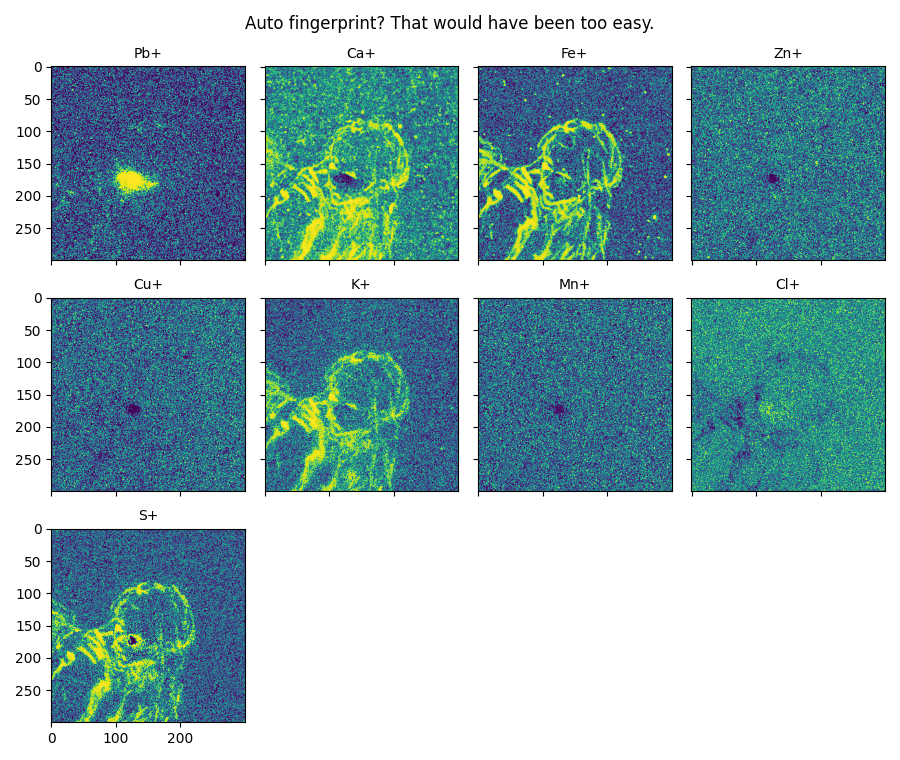

In [ ]:
H_img = H.reshape([h, w, n_components]).transpose([2, 0, 1])

H_img_histeq = [ske.equalize_hist(m) for m in H_img]

titles = [f'{elements[i]}+' for i in np.argmax(W, axis=1)]

fig, axs = multi_plot(*H_img_histeq, titles=titles)
fig.suptitle('Auto fingerprint? That would have been too easy.');
plt.tight_layout()


This little experiment with the NMF algorithm shows that calcium, iron, potassium and sulfur in the ink are not automatically combined into a single map. Would have been too easy. 

Ok, so we need to take a closer look into: 1) providing component information, or 2) alternative algorithms, such as UMAP?

## Hypersphere normalization 

**Not working yet...**

My expectation is that our spectral image is actually quite linear with respect to concentration of a given material. This would imply that we can eliminate the effect of concentration by projecting onto an (eleven dimensional) hypersphere. So, let's try that...

In [ ]:
element_stack = element_maps.transpose([1, 2, 0])

h, w, d = element_stack.shape

First we need to pre-normalize the individual element maps. 

In [ ]:
max_intensities = np.max(element_stack.reshape(h*w, d), axis=0)

In [ ]:
element_stack_prenorm = element_stack / max_intensities[None, None, :]

Now I need the hypersphere norm for each vector.  

In [ ]:
hnorms = np.sqrt(np.sum(element_stack_prenorm * element_stack_prenorm, axis=2))[:,:, None]

In [ ]:
element_stack_norm = element_stack / hnorms 
element_maps_norm = element_stack_norm.transpose([2, 0, 1])

In [ ]:
element_maps_norm.shape

(11, 1692, 1592)

<IPython.core.display.Javascript object>


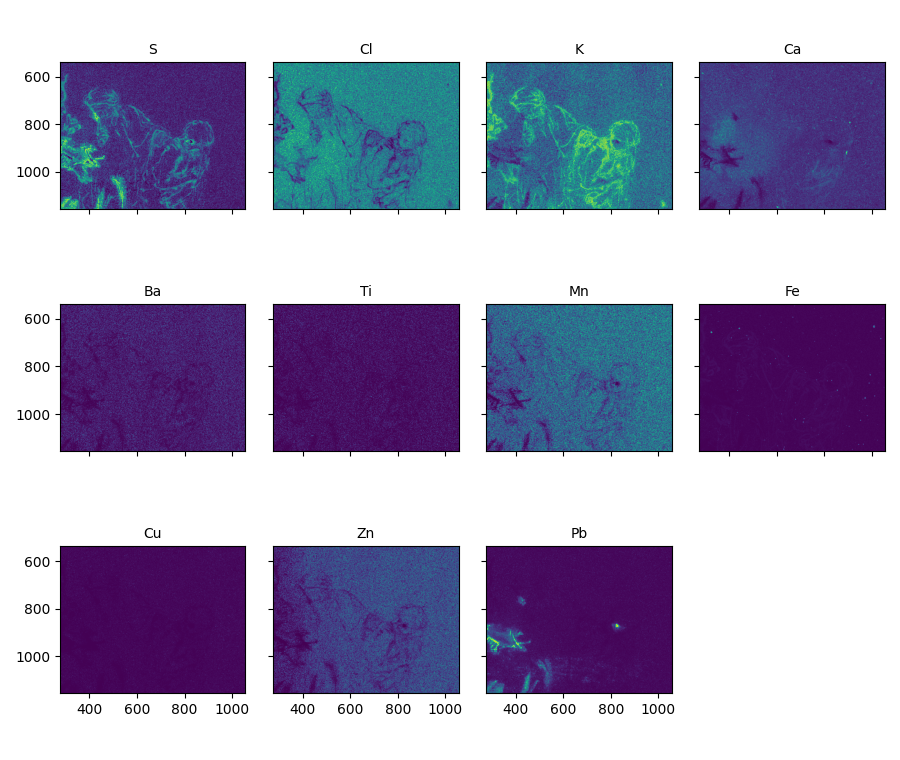

In [ ]:
multi_plot(*element_maps_norm, titles=elements);